In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical Data

In [4]:
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE",
               "ICSCHEME","AUXHEAT","EVAP"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

# Removing noise on heating scheme | the removed coluns are shots from 1996
DB5 = DB5[~DB5["AUXHEAT"].isin(["UNKNOWN"])]

This is what I had before to join comlumns.

```Python
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[num_features] ), columns = num_features)
data = pd.concat([DB5_,DB5[categorical]], axis=1, join="inner")
```

In [17]:
data = DB5.copy()
data = data[research_features + categorical + ["label"]]

### Implementation of RF

[`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

Univariate imputer for completing missing values with simple strategies. Replace missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.

In [7]:
X = data.drop("label", axis=1)
y = data["label"]

# Identify categorical and numerical features
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
num_features = X.select_dtypes(include=["int", "float"]).columns.tolist()

# Define preprocessing steps for categorical and numerical features
cat_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

# Combine preprocessing steps for all features using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_preprocessor, cat_features),
    ('num', num_preprocessor, num_features)
])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [8]:
# Define random forest classifier with preprocessor as a pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=71))
])

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

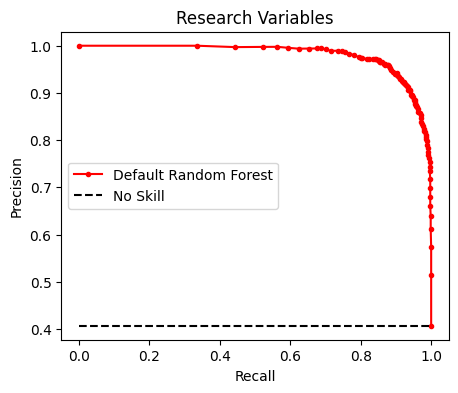

In [9]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [10]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.92036554, 0.94770063]),
 array([0.92398427, 0.94514388]),
 array([0.92217135, 0.94642053]),
 array([ 763, 1112]))

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [11]:
# Get feature importances from trained RF classifier
importances = model.named_steps["classifier"].feature_importances_

# Get feature names from column transformer
cat_encoder = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
feature_names = cat_encoder.get_feature_names_out(cat_features).tolist() + num_features

# Create a pandas dataframe to display feature importances
feature_importances = pd.DataFrame({"feature": feature_names, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

        feature    importance
0           TAV  1.554578e-01
1        NUSTAR  1.512705e-01
2       RHOSTAR  1.490952e-01
3            BT  8.240834e-02
4           NEL  6.908698e-02
..          ...           ...
90   CONFIG_BOT  1.348140e-05
91  DIVMAT_NONE  5.891842e-06
92   CONFIG_TOP  2.435518e-08
93   EVAP_CARBH  0.000000e+00
94   CONFIG_MAR  0.000000e+00

[95 rows x 2 columns]


In [12]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['TAV', 'NUSTAR', 'RHOSTAR', 'BT', 'NEL', 'BETASTAR', 'WALMAT_SS',
       'CONFIG_SN', 'EVAP_NONE', 'HYBRID_UNKNOWN', 'WALMAT_C',
       'HYBRID_NO', 'ELMTYPE_TYPE-I', 'ELMTYPE_UNKNOWN', 'HYBRID_HYBRID',
       'LIMMAT_C', 'DIVNAME_RDP', 'DIVNAME_DV-I', 'AUXHEAT_NB',
       'PREMAG_YES', 'PREMAG_NO', 'DIVMAT_W', 'PREMAG_UNKNOWN',
       'AUXHEAT_NBIC', 'WALMAT_IN', 'CONFIG_SN(L)', 'DIVNAME_MARKSR',
       'WALMAT_IN/C', 'ICSCHEME_NONE', 'HYBRID_YES', 'ICSCHEME_HMIN',
       'DIVNAME_UNKNOWN', 'LIMMAT_W', 'ICSCHEME_UNKNOWN', 'EVAP_BOR',
       'DIVNAME_DV-II', 'CONFIG_SN(U)', 'DIVNAME_MARK', 'DIVNAME_ILW',
       'ELMTYPE_TYPE-III', 'DIVMAT_C', 'WALMAT_W', 'LIMMAT_BE', 'EVAP_BE',
       'LIMMAT_NONE', 'CONFIG_DN', 'DIVNAME_MARKIAP', 'WALMAT_C-W',
       'DIVMAT_TI12', 'ELMTYPE_TYPE-II', 'EVAP_SILICON', 'EVAP_TI',
       'AUXHEAT_NBEC', 'DIVNAME_OPEN', 'DIVNAME_PLATES1',
       'DIVNAME_DV-III', 'ICSCHEME_H2NDHARM', 'ELMTYPE_TYPE-V',
       'DIVMAT_SS', 'AUXHEAT_IC', 'DIVNAME_ADP',

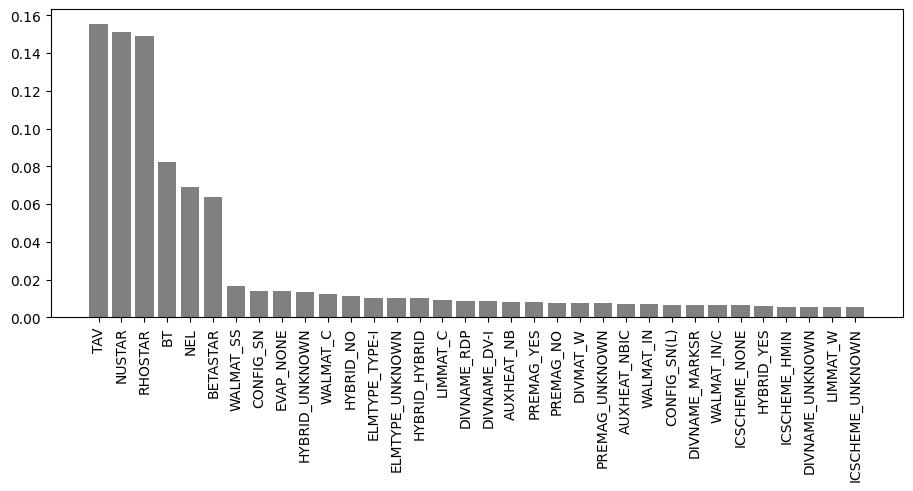

In [13]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [14]:
# Quite Important
df[df.importance > 1e-3]

,feature,importance
0,TAV,0.155458
1,NUSTAR,0.151271
2,RHOSTAR,0.149095
3,BT,0.082408
4,NEL,0.069087
5,BETASTAR,0.063982
6,WALMAT_SS,0.016344
7,CONFIG_SN,0.014167
8,EVAP_NONE,0.014059
9,HYBRID_UNKNOWN,0.013314


In [15]:
# Not so important
df[df.importance < 1e-3]

,feature,importance
58,DIVMAT_SS,8.515992e-04
59,AUXHEAT_IC,8.494892e-04
60,DIVNAME_ADP,8.146591e-04
61,AUXHEAT_NBECIC,8.052736e-04
62,DIVNAME_MARKIA,7.403214e-04
63,WALMAT_CSS,6.446441e-04
64,EVAP_BOROC,6.409976e-04
65,DIVMAT_C-W,6.075567e-04
66,ELMTYPE_TYPE-RF,5.813259e-04
67,LIMMAT_C-W,5.473255e-04


In [16]:
data["CONFIG"].unique()

array(['DN', 'SN', 'SN(L)', 'SN(U)', 'MAR', 'TOP', 'BOT', 'IW', 'DND',
       'LIM'], dtype=object)